In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
import re
import polars as pl
from pathlib import Path
from utils.helper import load_asap, get_min_max_scores, target_attribute

In [4]:
def find_rubric_path(rubric_dir: Path, target_prompt: int) -> Path:
    try:
        rubric_filename = next(
            f for f in os.listdir(rubric_dir)
            if f.endswith(".md") and str(target_prompt) in re.findall(r"\d+", f)
        )
        path = rubric_dir / rubric_filename
        print(f"Found rubric file for prompt {target_prompt}: {path}")
        return path
    except StopIteration:
        msg = f"Rubric file for prompt {target_prompt} not found in {rubric_dir}"
        raise FileNotFoundError(msg)

In [5]:
TARGET_PROMPT_ID = 5
ATTRIBUTS = target_attribute(TARGET_PROMPT_ID)

In [6]:
asap = load_asap(TARGET_PROMPT_ID, data_path="../data/asap_with_traits.csv")
asap = asap.select(['essay_id', 'essay'] + ATTRIBUTS)
asap

essay_id,essay,overall,content,prompt_adherence,language,narrativity
i64,str,i64,i64,i64,i64,i64
11827,"""In this memoir of Narciso Rodr…",2,2,2,2,2
11828,"""Throughout the excerpt from Ho…",2,3,3,3,3
11829,"""The mood the author created in…",3,2,2,2,2
11830,"""The mood created by the author…",1,1,0,1,1
11831,"""The mood created in the memoir…",3,4,4,4,4
…,…,…,…,…,…,…
13627,"""The mood of this memoir is non…",2,1,1,2,2
13628,"""The mood was created by the au…",0,0,0,0,0
13629,"""In the memoir ""Narciso Rodrigu…",4,3,3,2,3


In [7]:
queries = {}

for att in ATTRIBUTS:
    # Load llm prompts
    with open('../llm_prompts/vanilla_system.md', 'r') as f:
        system_prompt = f.read()
    with open('../llm_prompts/vanilla_user.md', 'r') as f:
        user_prompt = f.read()
    # Load essay topic
    with open(f'../llm_prompts/essay_prompts/prompt_{TARGET_PROMPT_ID}.md', 'r') as f:
        essay_topic = f.read()
    # Load rubric
    rubric_path = find_rubric_path(Path(f'../llm_prompts/{att}/'), TARGET_PROMPT_ID)
    with open(rubric_path, 'r') as f:
        rubric = f.read()
    for id, essay in asap.select(['essay_id', 'essay']).iter_rows():
        minscore, maxscore = get_min_max_scores(TARGET_PROMPT_ID, att)
        queries[f"{id}_{att}"] = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt.replace("{prompt}", essay_topic).replace("{rubric}", rubric).replace("{essay}", essay).replace("{minimum score value}", str(minscore)).replace("{maximum score value}", str(maxscore))}
        ]
    

Found rubric file for prompt 5: ../llm_prompts/overall/Overall_5.md
Found rubric file for prompt 5: ../llm_prompts/content/Content_5_6.md
Found rubric file for prompt 5: ../llm_prompts/prompt_adherence/Prompt_Adherence_5_6.md
Found rubric file for prompt 5: ../llm_prompts/language/Language_5_6.md
Found rubric file for prompt 5: ../llm_prompts/narrativity/Narrativity_5_6.md


In [6]:
import tiktoken

def count_total_tokens(queries, model="gpt-4o-mini"):
    enc = tiktoken.encoding_for_model(model)
    total_tokens = 0
    
    for qlist in queries.values():
        for msg in qlist:
            total_tokens += len(enc.encode(msg["content"]))
    
    return total_tokens

total = count_total_tokens(queries)
print(f"Total tokens: {total:,}")  # ← 3桁ごとにカンマ

Total tokens: 5,626,843


In [ ]:
from utils.gpt_api import LLMRunner

# MODEL = "gpt-4.1-2025-04-14"
# MODEL = "gpt-5-2025-08-07"
MODEL = "gpt-5-mini-2025-08-07"
MAX_WORKERS = 20
MAX_RETRIES = 6
BASE_SLEEP = 1.0  # 初回スリープ秒
OUTDIR = Path(f"../out_vanilla/{MODEL}/{TARGET_PROMPT_ID}")
JSONL_PATH = Path(f"../out_vanilla/{MODEL}/{TARGET_PROMPT_ID}/results.jsonl")

runner = LLMRunner(
    model=MODEL,
    outdir=OUTDIR,
    jsonl_path=JSONL_PATH,
    max_workers=20,
    max_retries=6,
    base_sleep=1.0,
)
runner.run_all(queries)

In [10]:
import json

results = []
errors = []

with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for line in f:
        try:
            entry = json.loads(line.strip())
        except json.JSONDecodeError:
            continue  # JSONとして読み込めない行はスキップ
        
        entry_id = entry.get("id")
        text = entry.get("text")

        essay_id = entry_id.split("_")[0]
        attribute = entry_id.split("_")[1]
        if len(entry_id.split("_")) == 3:
            attribute += "_" + entry_id.split("_")[2]
        
        # Get score
        try:
            text = json.loads(text)
            score = int(text.get("score"))
        except json.JSONDecodeError:
            errors.append({"id": entry_id, "error": "Invalid JSON in response"})
            score = None

        results.append({
            "essay_id": int(essay_id),
            "attribute": attribute,
            "score": score,
            # "raw_response": text
        })
print(f"Total results: {len(results)}")
print(f"Total errors: {len(errors)}")

Total results: 9025
Total errors: 0


In [11]:
result_df = pl.DataFrame(results).pivot(on="attribute", values="score").sort("essay_id")
result_df

essay_id,overall,content,prompt_adherence,language,narrativity
i64,i64,i64,i64,i64,i64
11827,2,3,3,2,2
11828,3,3,3,3,3
11829,3,2,3,2,2
11830,2,2,2,2,2
11831,3,4,3,3,3
…,…,…,…,…,…
13627,3,2,3,2,2
13628,1,1,1,1,1
13629,3,3,3,3,2


In [12]:
assert all(result_df['essay_id'] == asap['essay_id']) , "Essay IDs do not match!"

In [13]:
from sklearn.metrics import cohen_kappa_score

sum = 0
for att in ATTRIBUTS:
    gold_scores = asap.select(att).to_numpy()
    pred_scores = result_df.select(att).to_numpy()
    kappa = cohen_kappa_score(gold_scores, pred_scores, weights='quadratic', labels=[ i for i in range(minscore, maxscore+1)])
    print(f"Att: {att}, QWK: {kappa:.3f}")
    sum += kappa
print(f"Avg QWK: {sum/len(ATTRIBUTS):.3f}")

Att: overall, QWK: 0.586
Att: content, QWK: 0.445
Att: prompt_adherence, QWK: 0.424
Att: language, QWK: 0.514
Att: narrativity, QWK: 0.546
Avg QWK: 0.503


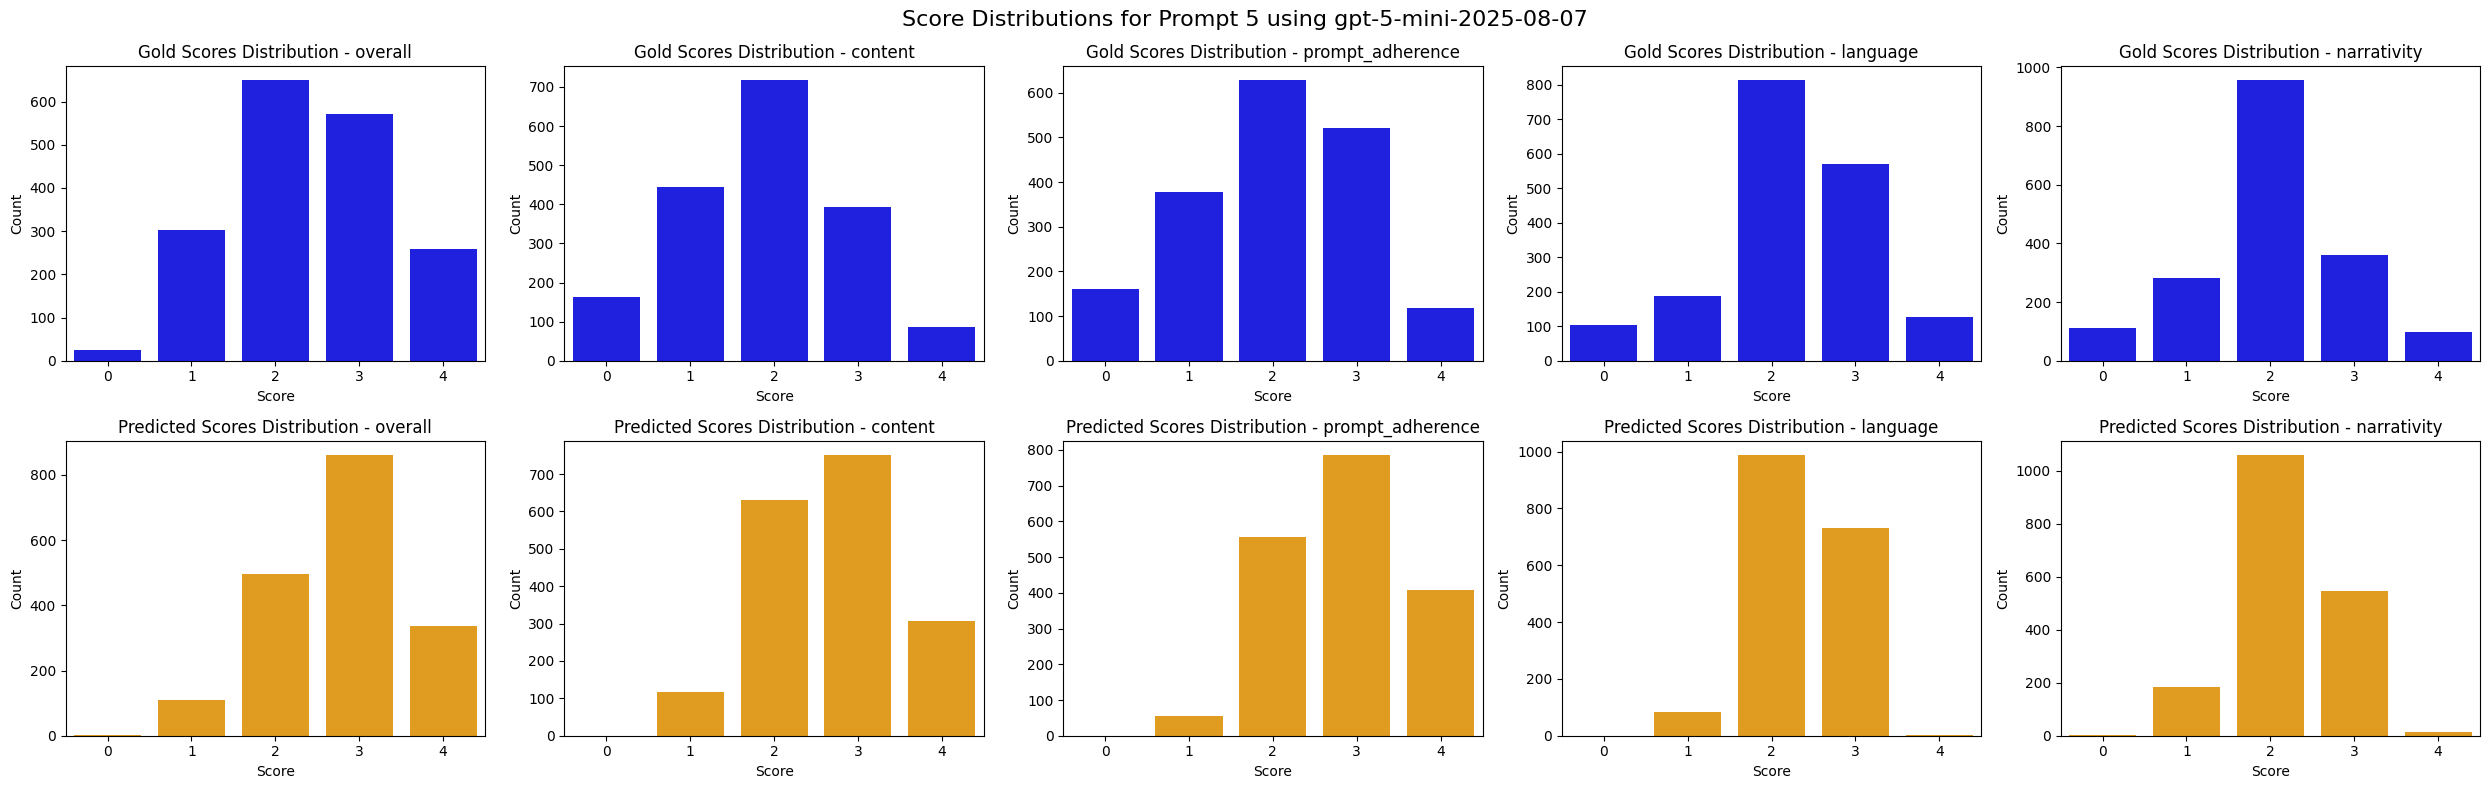

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, len(ATTRIBUTS), figsize=(5 * len(ATTRIBUTS), 8))

for i, att in enumerate(ATTRIBUTS):
    sns.countplot(
        data=asap,
        x=att,
        ax=axes[0, i],
        color='blue',
        order=list(range(minscore, maxscore + 1))
    )
    axes[0, i].set_title(f"Gold Scores Distribution - {att}")
    axes[0, i].set_xlabel("Score")
    axes[0, i].set_ylabel("Count")
    sns.countplot(
        data=result_df,
        x=att,
        ax=axes[1, i],
        color='orange',
        order=list(range(minscore, maxscore + 1))
    )
    axes[1, i].set_title(f"Predicted Scores Distribution - {att}")
    axes[1, i].set_xlabel("Score")
    axes[1, i].set_ylabel("Count")
plt.suptitle(f"Score Distributions for Prompt {TARGET_PROMPT_ID} using {MODEL}", fontsize=16)
plt.tight_layout()
plt.show()

In [2]:
TARGET_ATTRIBUTES = target_attribute(5)

# -----------------------------
# Data Preparation
# -----------------------------
# Load battles for all attributes
battles_dict: dict[str, pl.DataFrame] = {}
for attr in TARGET_ATTRIBUTES:
    csv_path = f"../sample/train_gemma-3n-e2b-it_5_12_{attr}_5000.csv"
    battles = pl.read_csv(csv_path)
    battles_dict[attr] = battles

In [18]:
battles_dict[TARGET_ATTRIBUTES[1]].describe()

statistic,essay1_id,essay2_id,predicted_preference,essay1_score,essay2_score,preference
str,f64,f64,f64,f64,f64,f64
"""count""",5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",12433.624,13030.8906,0.6481,1.8826,1.869,0.5026
"""std""",428.578988,421.161635,0.475354,0.989249,1.002217,0.426415
"""min""",11827.0,11861.0,0.0,0.0,0.0,0.0
"""25%""",12071.0,12736.0,0.0,1.0,1.0,0.0
"""50%""",12366.0,13105.0,1.0,2.0,2.0,0.5
"""75%""",12732.0,13386.0,1.0,3.0,3.0,1.0
"""max""",13582.0,13631.0,1.0,4.0,4.0,1.0
